In [242]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
matplotlib.rcParams['text.usetex'] = True

from codebase.sparse_regression import *
from codebase.utils import *

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
%autoreload
ds = CountryDataset()

C:\Users\kipr\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [148]:
mapping = {}

def func(c):
    if c in ds.iso.keys():
        try:
            code = continents.loc[ds.iso[c]]['Continent_Name']
            if type(code) != str:
                code = code[0]
            mapping[c] = code
            return code
        except KeyError:
            return np.NaN
    else:
        return np.NaN

a = pd.Series(trajectories.columns).apply(func)
a 

0        Asia
1      Europe
2      Africa
3      Europe
4      Africa
        ...  
183       NaN
184    Africa
185      Asia
186    Africa
187    Africa
Name: Country/Region, Length: 188, dtype: object

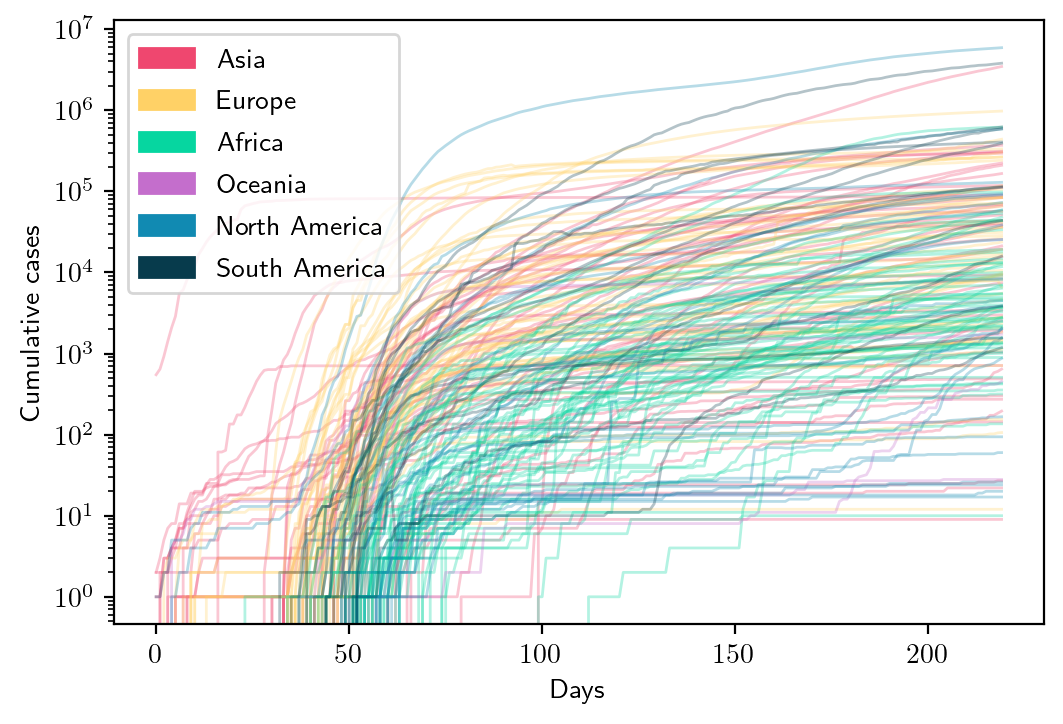

In [220]:
handles = []

trajectories = ds.hopkins_cases.transpose().iloc[4:].copy()
trajectories.columns = ds.hopkins_cases['Country/Region']
trajectories = trajectories.groupby(axis=1, level=0).sum()

continents = pd.read_csv('https://raw.githubusercontent.com/Kipre/files/master/hosted/country-and-continent.csv', index_col='Three_Letter_Country_Code')

f, ax = plt.subplots(dpi=200)

for continent, c in zip(['Asia', 'Europe', 'Africa',  'Oceania', 'North America', 'South America'],
                        [(0.9372549019607843, 0.2784313725490196, 0.43529411764705883),
 (1.0, 0.8196078431372549, 0.4),
 (0.023529411764705882, 0.8392156862745098, 0.6274509803921569),
 (0.7686274509803922, 0.43137254901960786, 0.8),
 (0.06666666666666667, 0.5411764705882353, 0.6980392156862745),
 (0.027450980392156862, 0.23137254901960785, 0.2980392156862745),]):
    handles.append(mpatches.Patch(color=c, label=continent))
    ax.plot(trajectories[[c for c in trajectories if mapping[c] == continent]].values, color=c, alpha=0.3, linewidth=1)
plt.yscale('log')
plt.legend(handles=handles)
plt.xlabel('Days')
plt.ylabel('Cumulative cases')
plt.savefig('all_trajectories.png')

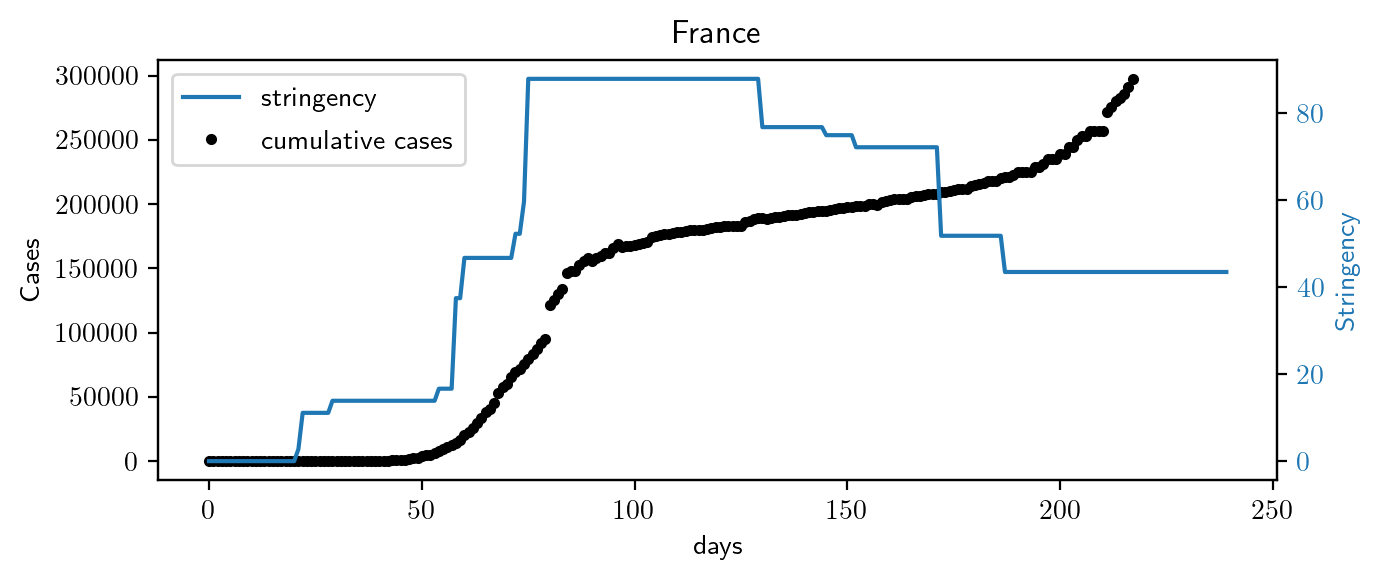

In [240]:
country = 'France'

country_data = ds.cumulative(country)

fig, ax1 = plt.subplots(dpi=200, figsize=(7, 3))

color = 'tab:red'
ax1.set_xlabel('days')
ax1.set_ylabel('Cases')
line1, = ax1.plot(country_data[:-1], 'k.', label='cases')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Stringency', color=color)
line2, = ax2.plot(ds.stringency(country)[:-1], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title(country)
plt.legend([line2, line1], ['stringency', 'cumulative cases'], loc='upper left')
plt.tight_layout()
plt.savefig('france_stringency.png')

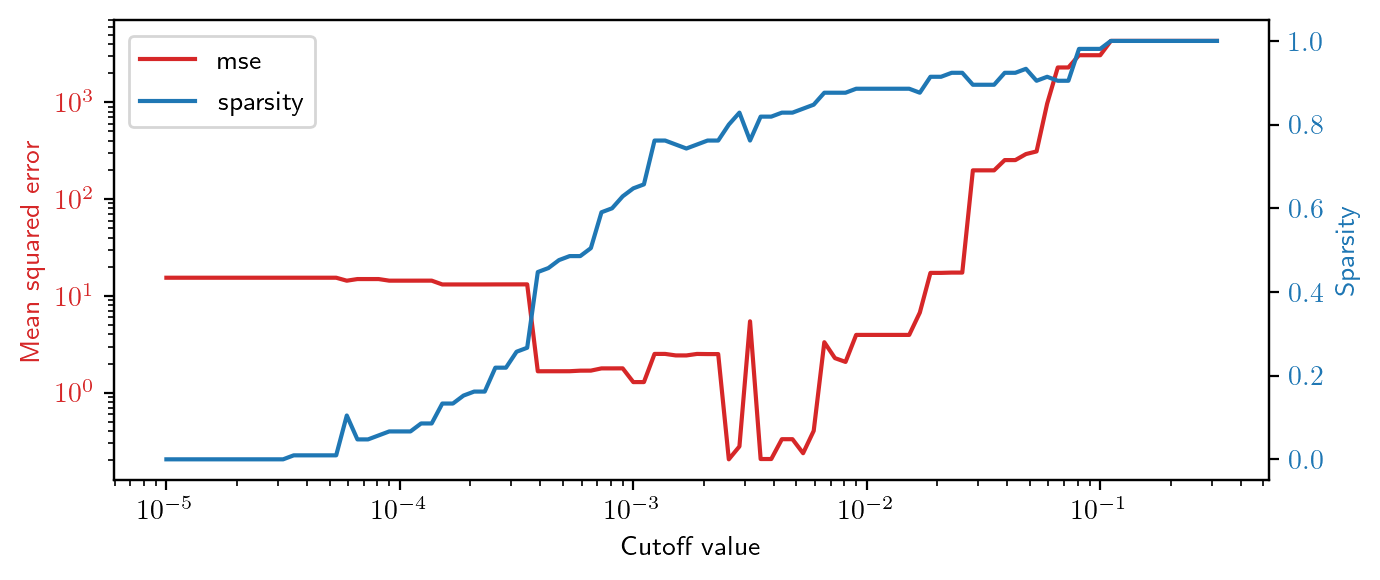

In [272]:
py_data = loadmat('data/py_odes.mat')

data = py_data['lorenz']

targets, m = make_targets(data, derivative=(derivative:=True))
targets /= py_data['t'][0][1]
augmented, _ = make_polynomials(m, 4)

rest = cutoff_mses(augmented, targets, -5, -0.5, num=100)

fig, ax1 = plt.subplots(dpi=200, figsize=(7, 3))

color = 'tab:red'
ax1.set_xlabel('Cutoff value')
ax1.set_ylabel('Mean squared error', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.plot(rest['cutoffs'], rest['mses'], color=color, label='mse')
ax1.tick_params(axis='y')

handles, labels = ax1.get_legend_handles_labels()

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Sparsity', color=color)
ax2.plot(rest['cutoffs'], rest['sparsity'], color=color, label='sparsity')
ax2.set_xscale('log')
ax2.tick_params(axis='y', labelcolor=color)
handles2, labels2 = ax2.get_legend_handles_labels()
handles += handles2
labels += labels2

fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.082,0.93))

fig.tight_layout()
plt.savefig('tradeoff.png')

| function   |   $x_{k+1}$ |
|:-----------|------------:|
| $1$        |    0        |
| $ x$       |    1.23826  |
| $ x^2$     |   -0.90029  |
| $ x^3$     |    1.12889  |
| $ x^4$     |   -0.470579 |

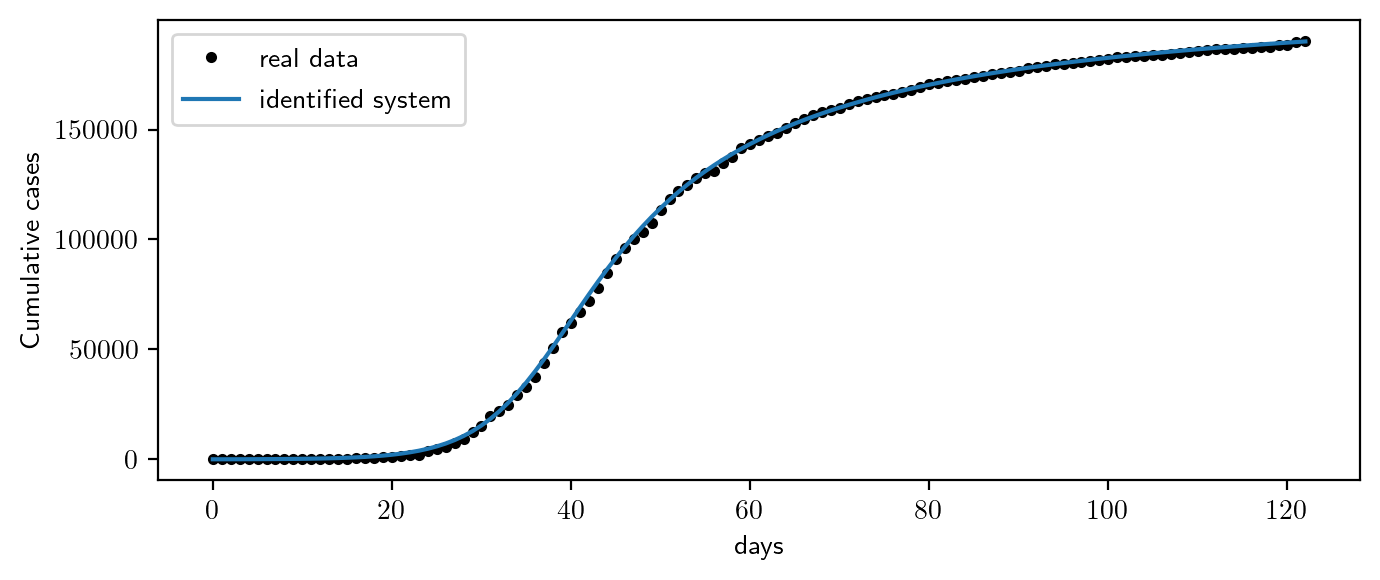

In [300]:
data = ds.cumulative('Germany')[27:150]/300000

m2, m1 = make_targets(data.reshape(-1, 1))

augmented, _ = make_polynomials(m1, max_degree=4)

weights, _ = sparse_regression(augmented, m2, cutoff=1e-3)

show_weights(weights)

t = range(len(data))

guess = integrate(weights, [0.0001], t)

fig, ax = plt.subplots(dpi=200, figsize=(7, 3))

ax.plot(data*300000, 'k.', label='real data')
ax.plot(guess*300000, label='identified system')
ax.set_xlabel('days')
ax.set_ylabel('Cumulative cases')
ax.legend()


fig.tight_layout()
plt.savefig('germany.png')

[[0.00341629 0.00341629 0.00341629 0.00341629 0.00341629 0.00341629
  0.00341629 0.00341629 0.00341629 0.00341629 0.00341629 0.00341629
  0.00341629 0.00341629 0.00341629]
 [0.09771133 0.10404006 0.11036879 0.11669751 0.12302624 0.12935497
  0.13568369 0.14201242 0.14834115 0.15466987 0.1609986  0.16732731
  0.17365605 0.17998478 0.1863135 ]
 [0.19200636 0.20296547 0.21392457 0.22488366 0.23584276 0.24680187
  0.25776097 0.26872006 0.27967918 0.29063824 0.30159739 0.31255645
  0.32351556 0.33447465 0.34543377]
 [0.28630143 0.30019253 0.3140837  0.3279748  0.3418659  0.35575706
  0.36964816 0.38353929 0.39743036 0.41132152 0.42521265 0.43910378
  0.45299488 0.46688601 0.48077708]
 [0.38059646 0.39572126 0.41084605 0.42597082 0.44109559 0.45622042
  0.47134516 0.48646995 0.50159478 0.51671952 0.53184432 0.54696912
  0.56209391 0.57721865 0.59234351]
 [0.47489151 0.48955163 0.50421172 0.51887184 0.5335319  0.54819202
  0.56285214 0.5775122  0.59217232 0.60683244 0.62149251 0.63615263
  0.

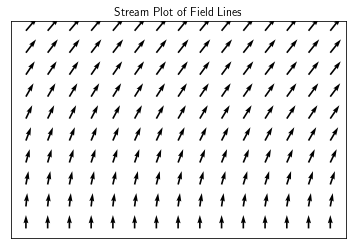

In [349]:
data = ds.cumulative('Germany', rescaling=-1)[27:150]

data = np.c_[data, range(len(data))]

m2, m1 = make_targets(data)

augmented, _ = make_polynomials(m1, max_degree=3)

weights, _ = sparse_regression(augmented, m2, cutoff=1e-3)

# show_weights(weights, variables=['x', 't'])

x = np.linspace(0, 122, 15)
y = np.linspace(0, 1, 10)


X, Y = np.meshgrid(x, y)
u = np.zeros_like(X)
v = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):    
        augmentation, _ = make_polynomials(np.array([Y[i, j], X[i, j]]), max_degree=3)
        u[i, j] = (augmentation.reshape(1, -1)@weights)[0, 0]
        v[i, j] = 1

fig, ax = plt.subplots()

print(u)
print(v)

ax.quiver(X,Y,u,v)#, density = 1
# ax.axis([0.5,2.1,0,2])
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
ax.set_title('Stream Plot of Field Lines')


plt.show()